In [26]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

## Read data

In [3]:
raw_train = pd.read_excel('../spectra_challenge_2024/data/train_dataset.xlsx', sheet_name=None)
train_y = pd.read_excel('../spectra_challenge_2024/data/reference_values.xlsx', 0, engine='openpyxl')['lactose content'].values

raw_test = pd.read_excel('../spectra_challenge_2024/data/test_dataset.xlsx', sheet_name=None)
test_y =  np.array([72, 62, 60, 58, 29, 48, 24, 19])

In [32]:
atr_method = "ShapleyValueSampling" # name of the attribution method, either "ShapleyValueSampling" or "FeatureAblation"
model_name = 'gi_rocket' # name of the model, only gi_rocket for now
nchunks = [10,15,20,25,30]

# Load and average the attributions
train_attrs = np.zeros((64,3424))
for nch in nchunks:
    train_attrs += np.genfromtxt(f'attribution/{model_name}_p75_{atr_method}_nch{nch}_train.csv', delimiter=',')
train_attrs = train_attrs/len(nchunks)

test_attrs = np.zeros((8,3424))
for nch in nchunks:
    test_attrs += np.genfromtxt(f'attribution/{model_name}_p75_{atr_method}_nch{nch}_test.csv', delimiter=',')
test_attrs = test_attrs/len(nchunks)


## Plot attribution profiles

Attributions with the same lactose concentration are stacked together to visualise the profile of the group.

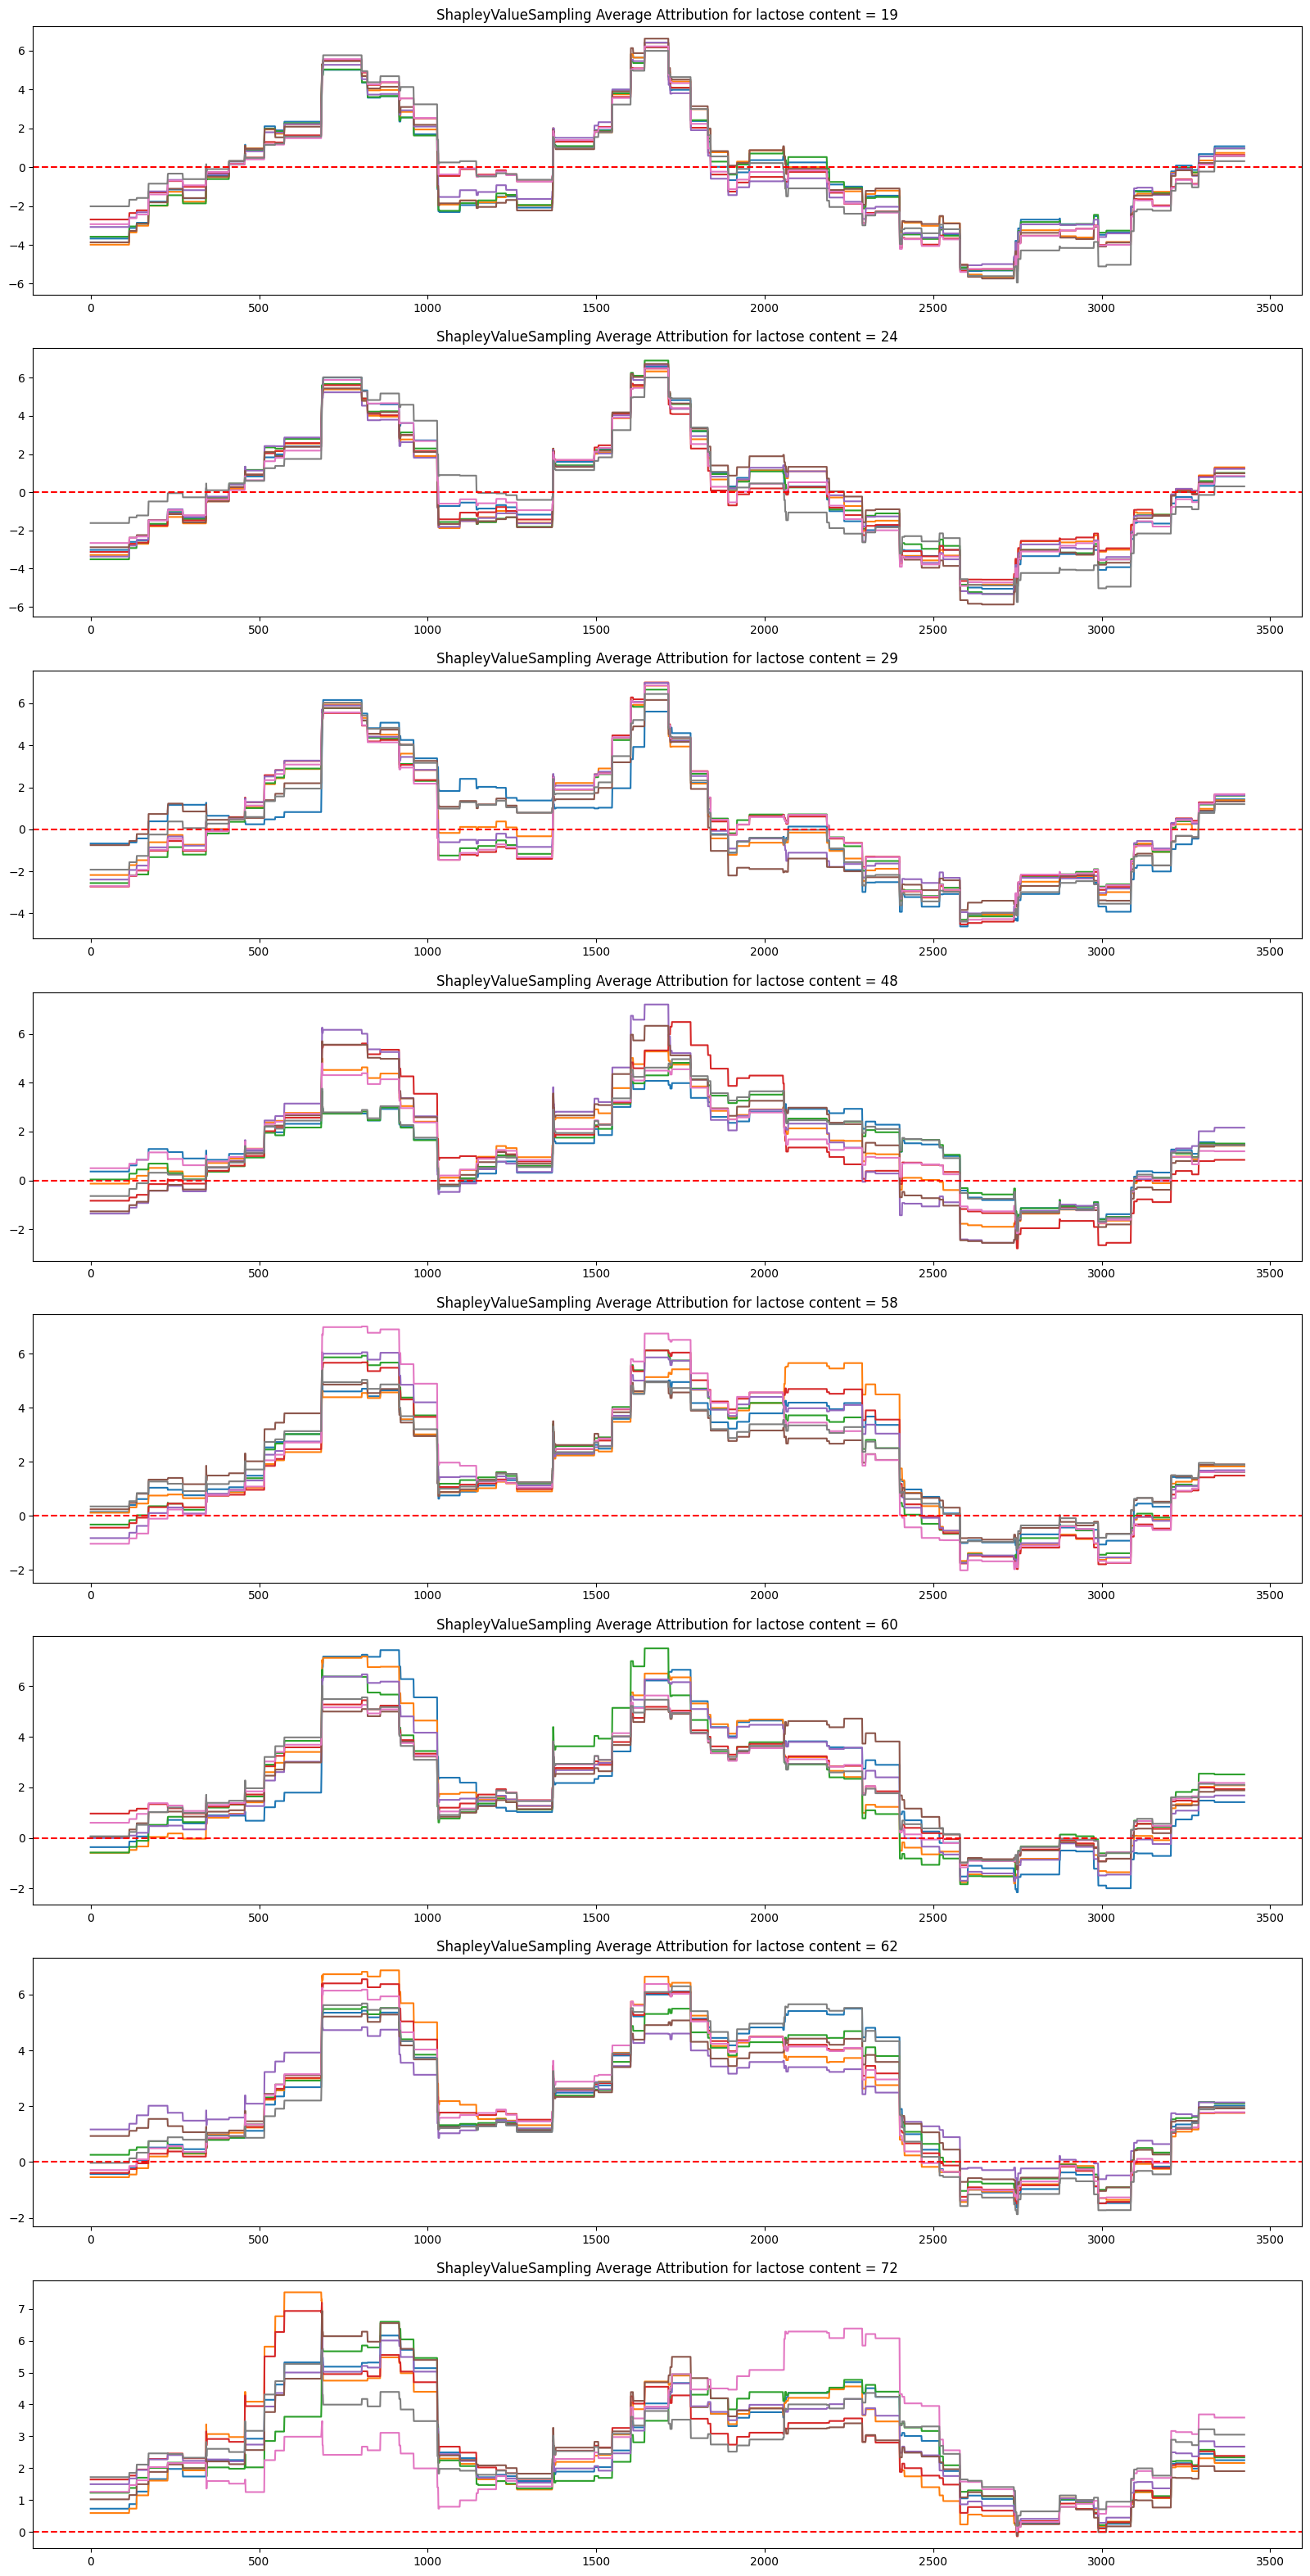

In [33]:
plt.figure(figsize=(20, 40))

for i,lc in enumerate(np.unique(train_y)):
    plt.subplot(8, 1, i+1)   

    for i in range(train_attrs.shape[0]):
        if train_y[i] == lc:
            plt.plot([ii for ii in range(train_attrs.shape[-1])], train_attrs[i,:])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{atr_method} Average Attribution for lactose content = {lc}")
plt.show()

## Plot invidiual sample and attribution

In [34]:
def plot_sample_and_attribution(sample_data, attribution):    

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 10),constrained_layout=True)    
    x = np.array([ii for ii in range(3424)])
    
    if attribution.min() < 0:
        cvals  = [attribution.min(), 0, attribution.max()]
    else:
        cvals  = [0,0, attribution.max()]
    colors = ["blue","gray","red"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)

    for p in range(sample_data.shape[0]):
        
        y = sample_data[p,:]    

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(attribution)
        lc.set_linewidth(2)

        line = axs[0].add_collection(lc)



    fig.colorbar(line, ax=axs[0])

    axs[0].set_xlim(x.min(), x.max())
    axs[0].set_ylim(sample_data.min() - 1, sample_data.max()+1)

    axs[1].plot(x, attribution)
    axs[1].axhline(y=0, color='r', linestyle='--')

    
    plt.show()

### Sample 12 in train data

sample12 - Lactose 72


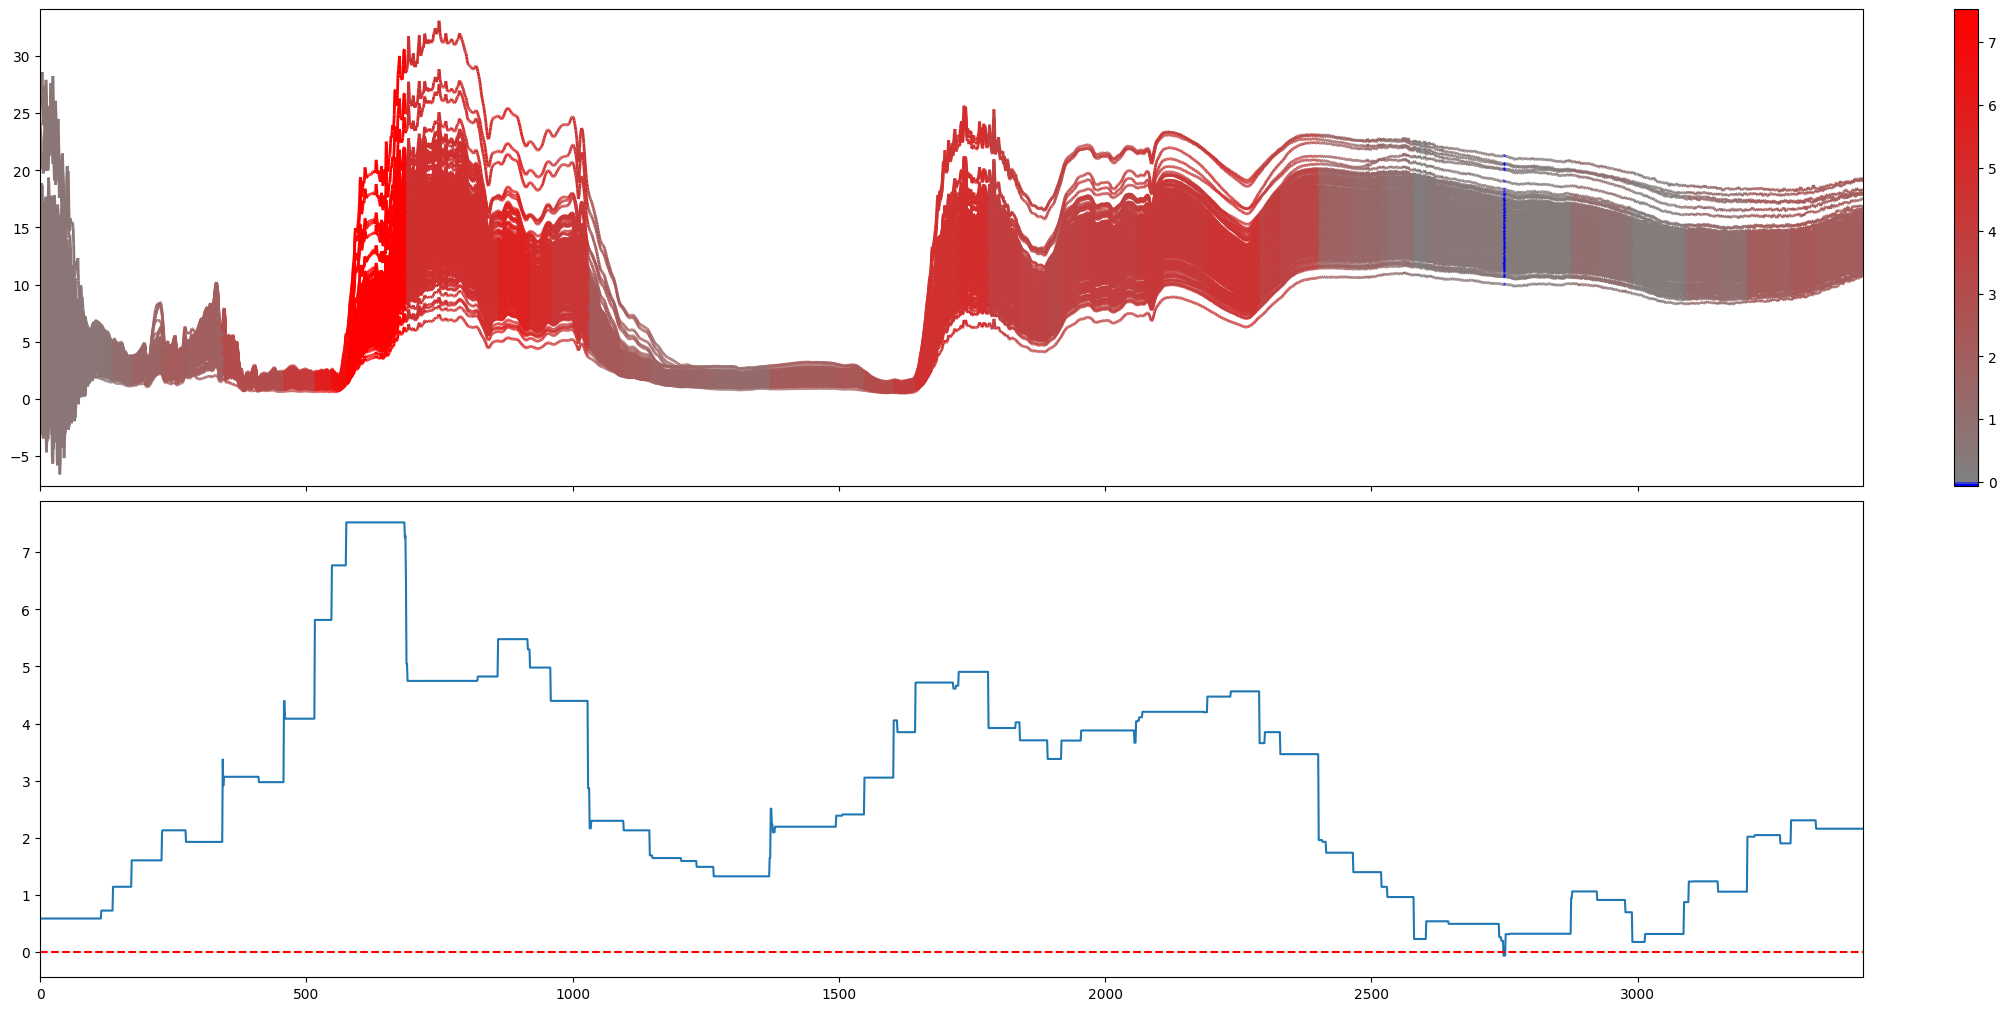

In [35]:
si = 10

sample_name = list(raw_train.keys())[si]

print(f"{sample_name} - Lactose {train_y[si]}")

plot_sample_and_attribution(raw_train[sample_name].values, train_attrs[si,:])

### Sample 42 in test data

sample42 - Lactose 24


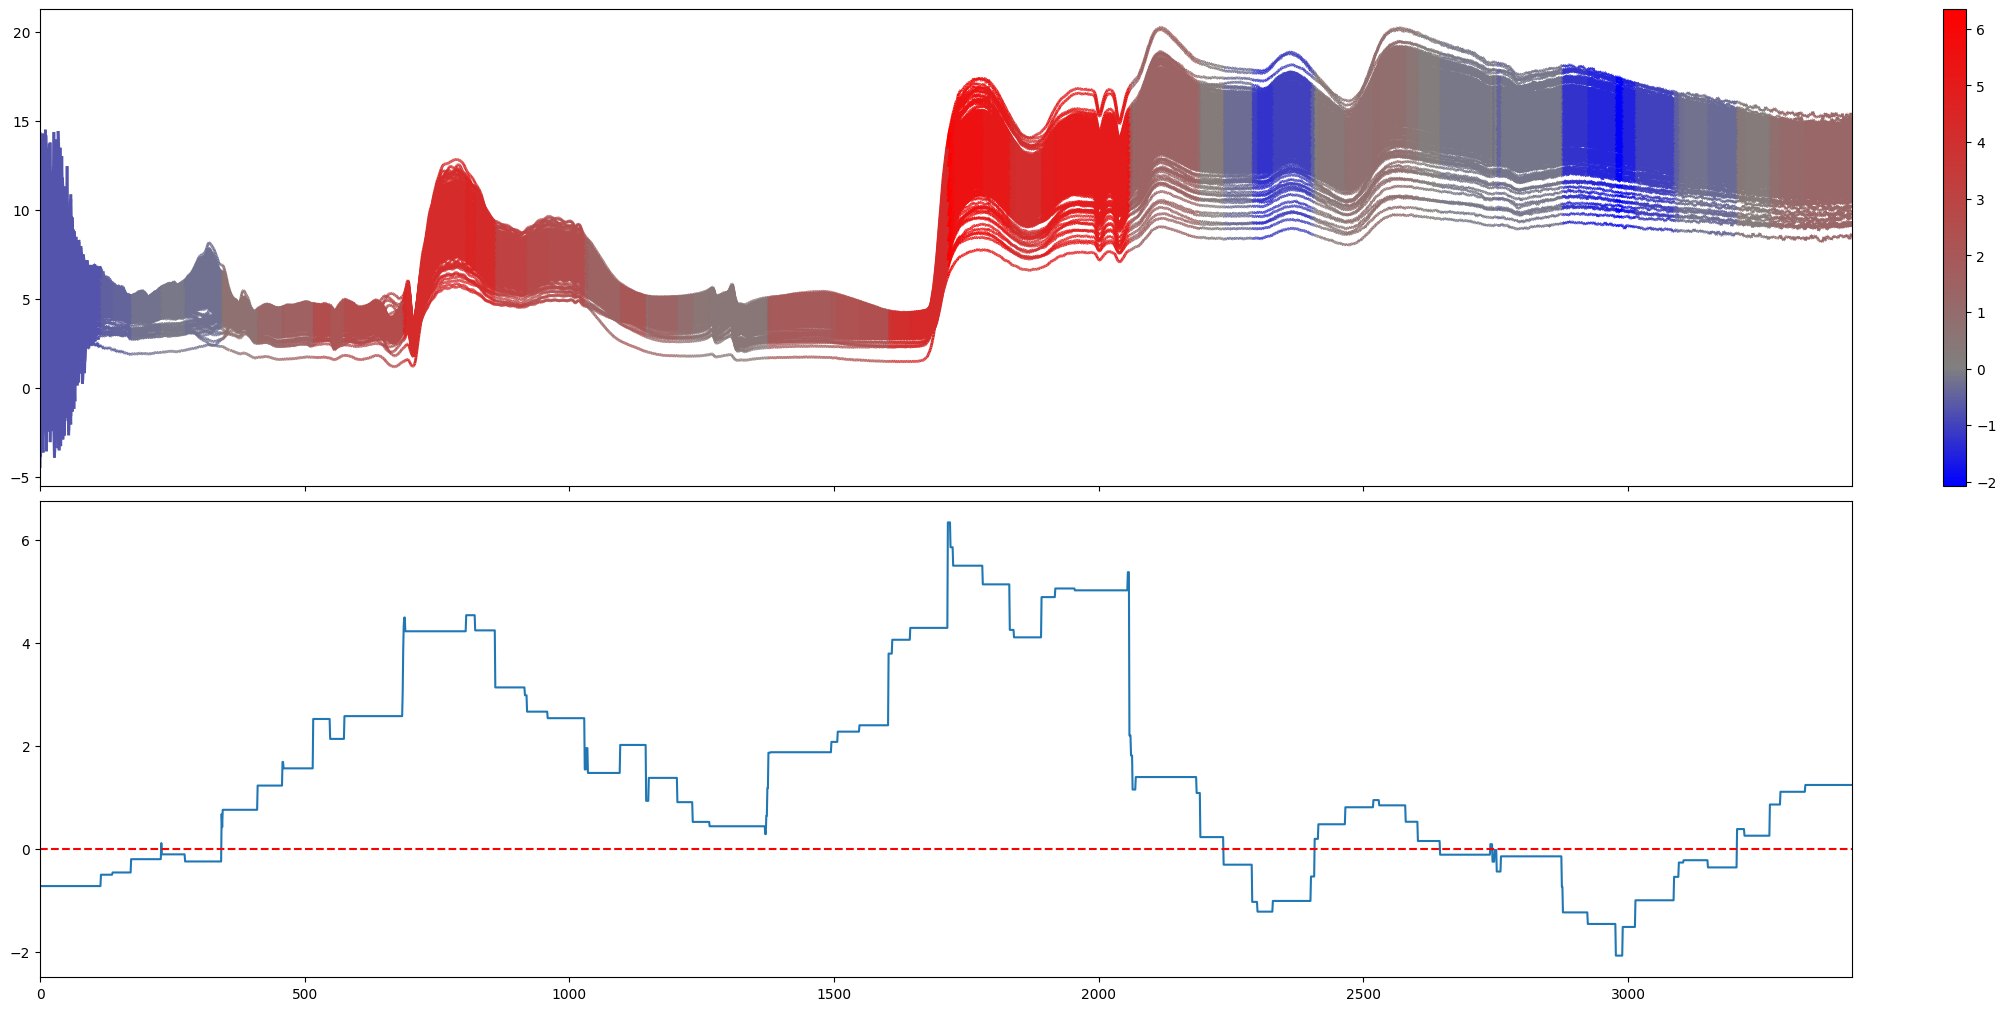

In [36]:
si = 6

sample_name = list(raw_test.keys())[si]

print(f"{sample_name} - Lactose {test_y[si]}")

plot_sample_and_attribution(raw_test[sample_name].values, test_attrs[si,:])